In [49]:
from CaNH2_package import CaNH2_molecule
import numpy as np
import matplotlib.pyplot as plt

molecule = CaNH2_molecule(vibronic_states_to_include=("X","A","B"))

In [50]:
def get_total_d2(s1, s2, TDMs):
    s = 0
    for q in (-1,0,1):
        s += np.abs(TDMs[q][s1,s2])**2
    return s

In [51]:
states = molecule.eigenstates
Es = molecule.Es
TDMs = molecule.TDMs

for i, s in enumerate(states):
    s.E = Es[i] / 1000

In [52]:
X_states_111 = []
for i in range(len(states)):
    if states[i][0].elec == "X" and states[i].ka == 1 and states[i].kc == 1 and states[i][0].N == 1:
        X_states_111.append(states[i])

X_states_211 = []
for i in range(len(states)):
    if states[i][0].elec == "X" and states[i].ka == 1 and states[i].kc == 1 and states[i][0].N == 2:
        X_states_211.append(states[i])

B_states_101_J32 = []
for i in range(len(states)):
    if states[i][0].elec == "B" and states[i][0].J == 3/2 and states[i].ka == 0 and states[i].kc == 1 and states[i][0].N == 1:
        B_states_101_J32.append(states[i])

In [58]:
sB = 0
for s in X_states_111 + X_states_111:
    for s1 in B_states_101_J32:
        sB += get_total_d2(s1, s,TDMs)

s211 = 0
for s in X_states_211:
    total = 0
    for s1 in B_states_101_J32:
        total += get_total_d2(s1, s, TDMs)
    print(total/sB*100)
    s211 += total
print(s211/sB)

1.2485622177754134
1.2485622177674938
1.2485622177337719
1.2485622177333824
7.500426743044371
7.500426742881092
7.50042674283196
7.500426742778861
7.500426742717857
7.500426742571998
0.499968093278362


In [54]:
import numpy as np
from scipy.integrate import solve_ivp

def simulate_rate_equations(
    absorption_weights: np.ndarray,
    decay_weights: np.ndarray,
    absorption_rate: float,
    decay_rate: float,
    g0: np.ndarray,
    e0: np.ndarray,
    t_span: tuple[float, float],
    t_eval: np.ndarray | None = None,
    method: str = "RK45",
    stim_emission_rate: float | None = None,
):
    """
    Simulate rate-equation dynamics for N_g ground and N_e excited states,
    including spontaneous decay and stimulated emission.

    New/changed bits:
      - Stimulated emission uses the same (N_g x N_e) coupling matrix as absorption.
      - Set `stim_emission_rate=None` to use `absorption_rate` (Einstein B symmetry).

    Population flow terms:
      Absorption (g -> e):
        -g_i:  -S * g_i * sum_j A[i,j]
        +e_j:  +S * sum_i A[i,j] * g_i
      Spontaneous decay (e -> g):
        -e_j:  -Gamma * e_j
        +g_i:  +Gamma * P[i,j] * e_j, with P columns normalized from `decay_weights`.
      Stimulated emission (e -> g):
        -e_j:  -S_stim * e_j * sum_i A[i,j]
        +g_i:  +S_stim * sum_j A[i,j] * e_j

    Parameters
    ----------
    absorption_weights : (N_g, N_e) array_like
        Nonnegative weights for absorption g_i -> e_j (also used for stimulated emission).
    decay_weights : (N_g, N_e) array_like
        Nonnegative weights for spontaneous decay e_j -> g_i (column-normalized internally).
    absorption_rate : float
        Scalar absorption rate (same for all ground states).
    decay_rate : float
        Total spontaneous decay rate out of each excited state (same for all j).
    g0 : (N_g,) array_like
        Initial ground-state populations.
    e0 : (N_e,) array_like
        Initial excited-state populations.
    t_span : (t0, tf)
        Integration time interval.
    t_eval : array_like or None
        Times at which to store the computed solution.
    method : str
        ODE solver (e.g., "RK45", "BDF").
    stim_emission_rate : float or None
        Scalar stimulated-emission rate. If None, equals `absorption_rate`.

    Returns
    -------
    result : scipy.integrate.OdeResult
        With convenience attributes:
          - result.g : (N_g, len(t)) ground populations
          - result.e : (N_e, len(t)) excited populations
    """
    A = np.asarray(absorption_weights, dtype=float)
    B = np.asarray(decay_weights, dtype=float)
    g0 = np.asarray(g0, dtype=float)
    e0 = np.asarray(e0, dtype=float)

    # Shape & value checks
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("absorption_weights and decay_weights must be 2D arrays.")
    Ng, Ne = A.shape
    if B.shape != (Ng, Ne):
        raise ValueError("absorption_weights and decay_weights must both be (N_g, N_e).")
    if g0.shape != (Ng,) or e0.shape != (Ne,):
        raise ValueError("g0 shape must be (N_g,), e0 shape must be (N_e,).")
    if np.any(A < 0) or np.any(B < 0):
        raise ValueError("All weights must be nonnegative.")
    if absorption_rate < 0 or decay_rate < 0:
        raise ValueError("Rates must be nonnegative.")
    if np.any(g0 < 0) or np.any(e0 < 0):
        raise ValueError("Initial populations must be nonnegative.")

    # Normalize decay weights column-wise -> branching matrix P (Ng x Ne)
    col_sums = B.sum(axis=0, keepdims=True)  # (1, Ne)
    with np.errstate(divide='ignore', invalid='ignore'):
        P = np.divide(B, col_sums, out=np.full_like(B, 1.0 / Ng), where=col_sums > 0)

    # Precompute absorption/stimulated-emission aggregated weights
    A_row_sums = A.sum(axis=1)  # for ground-state absorption outflow
    A_col_sums = A.sum(axis=0)  # for excited-state stimulated-emission outflow

    y0 = np.concatenate([g0, e0])
    S_abs = float(absorption_rate)
    S_stim = float(S_abs if stim_emission_rate is None else stim_emission_rate)

    def rhs(t, y):
        g = y[:Ng]
        e = y[Ng:]

        # Absorption terms
        g_loss_abs = S_abs * g * A_row_sums           # (Ng,)
        e_gain_abs = S_abs * (A.T @ g)                # (Ne,)

        # Spontaneous decay terms
        e_loss_dec = decay_rate * e                   # (Ne,)
        g_gain_dec = decay_rate * (P @ e)             # (Ng,)

        # Stimulated emission terms
        e_loss_stim = S_stim * e * A_col_sums         # (Ne,)
        g_gain_stim = S_stim * (A @ e)                # (Ng,)

        dgdt = -g_loss_abs + g_gain_dec + g_gain_stim
        dedt = +e_gain_abs - e_loss_dec - e_loss_stim
        return np.concatenate([dgdt, dedt])

    sol = solve_ivp(
        rhs,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        method=method,
        vectorized=False,
        rtol=1e-7,
        atol=1e-10,
    )

    sol.g = sol.y[:Ng, :]
    sol.e = sol.y[Ng:, :]
    return sol


In [61]:
1/0.65

1.5384615384615383

In [7]:
ground_states = X_states_111 + X_states_211
excited_states = B_states_101_J32

A = np.zeros((len(ground_states), len(excited_states)))
B = np.zeros((len(ground_states), len(excited_states)))

for i, g in enumerate(ground_states):
    for j, e in enumerate(excited_states):
        B[i,j] = get_total_d2(g, e, TDMs)
        if g in X_states_211:
            A[i,j] = np.abs(TDMs[0][g,e])**2 # lasers have linear polarization

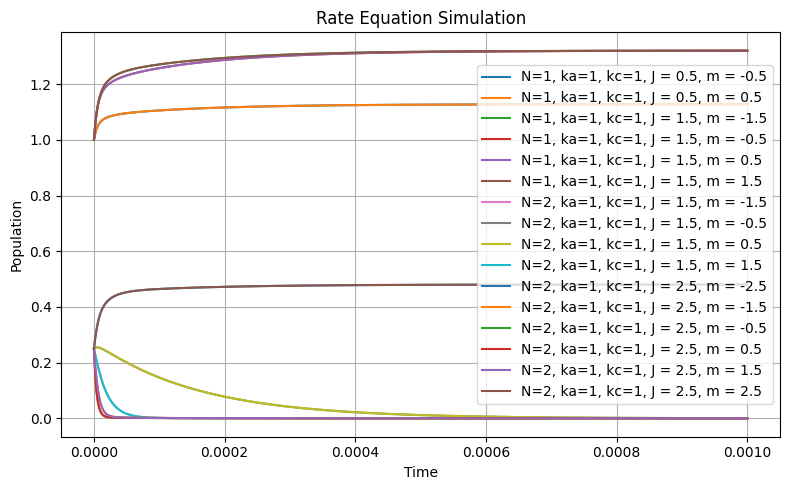

In [27]:

S = 2e6      # absorption_rate (same for all ground states)
Gamma = 20e6  # decay_rate (same for all excited states)

g0 = np.array([1]*len(X_states_111) + [0.25]*len(X_states_211))
e0 = np.array([0]*len(excited_states))

t_eval = np.linspace(0.0, 1000e-6, 501)
sol = simulate_rate_equations(A, B, S, Gamma, g0, e0, t_span=(0.0, 1000e-6), t_eval=t_eval)

# Access populations:
g_t = sol.g   # shape (2, 501)
e_t = sol.e   # shape (3, 501)

populations = []
# --- Plot results ---
plt.figure(figsize=(8, 5))

for i in range(sol.g.shape[0]):
    plt.plot(sol.t, sol.g[i], label=f"{ground_states[i].label[19:]}")


plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Rate Equation Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rotational_pumping.png",dpi=300)
plt.show()

In [33]:
ground_states[14]

|elec = X, S = 0.5, N=2, ka=1, kc=1, J = 2.5, m = 1.5> = 0.71 |elec=X, S=0.5, N=2, k=-1, J=2.5, m=1.5> + 0.71 |elec=X, S=0.5, N=2, k=1, J=2.5, m=1.5> 

In [45]:
N1_population = np.sum(sol.g[3:5][:,-1])
N2_population = np.sum(sol.g[11:15][:,-1])
print(N1_population, N2_population)

2.640500215699772 1.589172546588974e-05


In [46]:
sol.g[:][:,-1]

array([1.12822712e+00, 1.12822712e+00, 1.32029529e+00, 1.32025011e+00,
       1.32025011e+00, 1.32029530e+00, 2.38682700e-06, 4.90634171e-04,
       4.90634181e-04, 2.38682936e-06, 4.80726232e-01, 4.14173764e-06,
       3.80412368e-06, 3.80412408e-06, 4.14174007e-06, 4.80726230e-01])

In [47]:
(1.32 + 1.13)/2

1.225

In [14]:
4 * 0.3 / 10 / 0.36

0.3333333333333333

In [ ]:
0.3